In [23]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import gutenberg
nltk.download('punkt')
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mille\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\mille\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [24]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [25]:
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processingwnload()

emma_paras=[]

In [26]:

for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


# tfidf in sklearn

In [27]:

from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.40, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [28]:
#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[3])
print('Tf_idf vector:', tfidf_bypara[3])

Number of features: 1948
Original sentence: To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being seriously accepted as soon as possible .
Tf_idf vector: {'accepted': 0.15893875642089123, 'seriously': 0.14850853274134498, 'resolved': 0.15489271400624896, 'effect': 0.1514718338876578, 'fail': 0.16389071212512824, 'ard

# Dimension reduction

In [29]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.19430770996884
Component 0:
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !"    0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !"    0.999291
" Oh !     0.999291
" Oh !     0.999291
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634130
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.570671
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.564156
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elto

# Sentence similarity

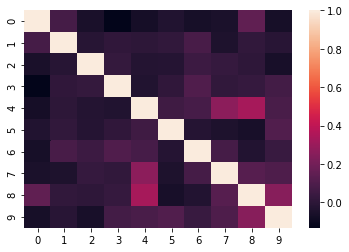

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [30]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

# Drill 0: Test set

Now it's your turn: Apply our LSA model to the test set. Does it identify similar sentences for components 0 through 4?

In [31]:
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 49.37384492418547
Component 0:
" Oh !       0.99992
" Oh !"      0.99992
" Oh no !    0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.613211
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                             

Component 0 - "Oh!"s

Component 1 is the same

Component 2 - "Ah!"s

Components 3 and 4 different then the previous components

Variance 49% captured


# Drill 1a: Tweaking tf-idf

Go back up to the code where we originally translated the text from words to numbers. There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well. We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities. Change things up a few times and see how that affects the results of the LSA. Write up your observations and share them with your mentor.

In [34]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=20, ##### only use words that appear at least twemty time
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [35]:
#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[1])
print('Tf_idf vector:', tfidf_bypara[1])

Number of features: 155
Original sentence: " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
Tf_idf vector: {'obliged': 0.4943033418343742, 'yes': 0.40598401305625287, 'kind': 0.5010380180544194, 'sir': 0.45745607503870644, 'did': 0.36129770448812815}


## Dimension reduction 

Reducing features to 100

In [36]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 85.92651079729471
Component 0:
Emma was most agreeably surprized . Mr .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         0.739733
" 

## Sentence Similarity 

Range(7)

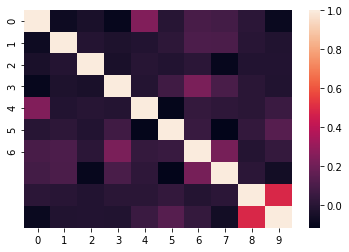

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [39]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(7))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(7):
    print(i,sim_matrix.index[i])

In [40]:
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 88.24127223210027
Component 0:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                  0.632428
" No , no ," said Emma , " it will not reckon low .                                                                                                                                                                                       0.627823
" Very likely ," said Emma " nothing more likely .                                                                                                                                                                                        0.627823
" Emma ," said she , " this paper is worse than I expected .                                                                                                                                       

### Results 

When changes to the hyperparameters: max_df=0.5 and min_df=20

Captured 88% of the variance in the adjusted model. 

# Drill 1b: Tweaking tf-idf

Made changes to max_df=0.75 and min_df=35
Add an analyzer 'char'
ngram_range = (7, 10) 

In [58]:

vectorizer = TfidfVectorizer(max_df=0.75, # drop words that occur in more than half the paragraphs
                             min_df=35, ##### only use words that appear at least twemty time
                             stop_words='english',
                             analyzer = 'char',
                             ngram_range=(7, 10),
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [59]:
#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[4])
print('Tf_idf vector:', tfidf_bypara[4])

Number of features: 1202
Original sentence: Emma smiled and answered " My visit was of use to the nervous part of her complaint , I hope ; but not even I can charm away a sore throat ; it is a most severe cold indeed .
Tf_idf vector: {' i hope ': 0.2830095484665526, 'i hope ': 0.2830095484665526, ' i hope': 0.2815470419361341, ' answer': 0.27227477008164674, ' to the ': 0.24963403101384132, 'to the ': 0.24004011164070047, ' to the': 0.2407213718887464, ' it is ': 0.23612124883885058, ' ; but ': 0.21284458778359083, 'it was ': 0.2222689838541315, ' indeed ': 0.2457429849737961, 'indeed ': 0.2457429849737961, ' indeed': 0.2457429849737961, ' of her ': 0.24353433435220914, 'of her ': 0.24353433435220914, ' of her': 0.24141120167266755}


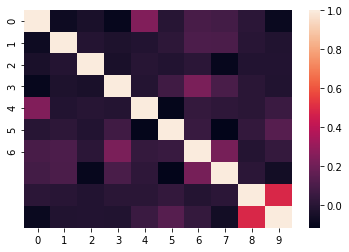

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [60]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(7))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(7):
    print(i,sim_matrix.index[i])

In [61]:
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(7):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 74.11072794248456
Component 0:
Mr . Woodhouse could not be soon reconciled ; but the worst was overcome , the idea was given ; time and continual repetition must do the rest . To Emma ' s entreaties and assurances succeeded Mr . Knightley ' s , whose fond praise of her gave the subject even a kind of welcome ; and he was soon used to be talked to by each , on every fair occasion . They had all the assistance which Isabella could give , by letters of the strongest approbation ; and Mrs . Weston was ready , on the first meeting , to consider the subject in the most serviceable light  first , as a settled , and , secondly , as a good one  well aware of the nearly equal importance of the two recommendations to Mr . Woodhouse ' s mind . It was agreed upon , as what was to be ; and every body by whom he was used to be guided assuring him that it would be for his happiness ; and having some feelings himself which almost admitted it , he began to th

# Results 

When changing the df ranges and adding an analyzer 'char'. The model did not do as great of a job capturing the variance. 

Variance = 74% 

